# Approach 1

In [8]:
# Importing modules
import numpy as np 
import pandas as pd
import keras

In [35]:
# Reading in the data
data = pd.read_csv('../data/processed/stocks/nse_scraped/TCS.csv', 
                   thousands=',')

# Isolating the date and close price
data = data[['Date', 'Close']]
new_data = data.loc[:,:]
new_data.shape

(4369, 2)

In [36]:
# Feature Pre Processing
new_data = new_data.drop(['Date'], axis = 1)
new_data = new_data.reset_index(drop = True)
T = new_data.values
T = T.astype('float32')
T = np.reshape(T, (-1, 1))

In [37]:
# Min-max scaling to get the values in the range [0,1] to optimize convergence speed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
T = scaler.fit_transform(T)


In [38]:
# 80-20 split
train_size = int(len(T) * 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]


In [39]:
train.shape,test.shape

((3495, 1), (874, 1))

In [40]:
# Method for create features from the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)


In [41]:
# Roughly one month of trading 
window_size = 7
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)


In [42]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((3487, 7), (3487,), (866, 7), (866,))

In [43]:


# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

# Make sure that the number of rows in the dataset = train rows + test rows
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T_shape, train_shape, test_shape))

# Model imports
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
""" from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout """

# Setting seed for reproducibility 
tf.random.set_seed(11)
np.random.seed(11)

# Building model
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', #return_sequences = True, 
               input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

# Optional additional model layer to make a deep network. If you want to use this, uncomment #return_sequences param in previous add
"""
model.add(LSTM(units = 25, activation = 'relu'))
model.add(Dropout(0.2))
"""

# Output layer
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')



history = model.fit(X_train, Y_train, epochs = 30, batch_size = 20, validation_data = (X_test, Y_test))

"""
Loading the best model and predicting
"""


# Predicting and inverse transforming the predictions

train_predict = model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

# Inverse transforming the actual values, to return them to their original values
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

# Reshaping 
Y_hat_train = np.reshape(Y_hat_train, newshape =X_train.shape[0])
Y_hat_test = np.reshape(Y_hat_test, newshape = X_test.shape[0])

Y_train = np.reshape(Y_train, newshape = X_train.shape[0])
Y_test = np.reshape(Y_test, newshape = X_test.shape[0])

# Model performance evaluation
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

False
Epoch 1/30
175/175 [==============================] - 5s 19ms/step - loss: 0.0311 - val_loss: 6.2774e-04
Epoch 2/30
175/175 [==============================] - 3s 15ms/step - loss: 0.0032 - val_loss: 5.5995e-04
Epoch 3/30
175/175 [==============================] - 3s 16ms/step - loss: 0.0028 - val_loss: 7.1071e-04
Epoch 4/30
175/175 [==============================] - 3s 16ms/step - loss: 0.0026 - val_loss: 6.2953e-04
Epoch 5/30
175/175 [==============================] - 3s 18ms/step - loss: 0.0025 - val_loss: 6.6788e-04
Epoch 6/30
175/175 [==============================] - 3s 18ms/step - loss: 0.0022 - val_loss: 5.0095e-04
Epoch 7/30
175/175 [==============================] - 4s 25ms/step - loss: 0.0021 - val_loss: 5.0840e-04
Epoch 8/30
175/175 [==============================] - 5s 27ms/step - loss: 0.0020 - val_loss: 5.1109e-04
Epoch 9/30
175/175 [==============================] - 4s 20ms/step - loss: 0.0018 - val_loss: 4.7095e-04
Epoch 10/30
175/175 [============================

In [50]:
print(Y_test)

[2162.85009754 2064.80012382 2102.64982847 2077.55007322 2091.80001667
 2043.59991768 1979.94988001 1918.30012467 1949.50000085 1962.30002262
 1929.40008062 1913.1999272  1902.99996768 1843.65005808 1848.4998937
 1852.99987584 1799.09990833 1871.00002211 1894.8000728  1938.14990076
 1935.74991028 1913.44985364 1890.8500159  1932.69984982 1942.15003002
 1909.20001565 1914.84992066 1934.94984089 1880.65005638 1872.84986963
 1886.5999602  1902.44982473 1878.25006591 1811.99996598 1812.55000009
 1846.09990322 1890.25001828 1983.8999369  1960.55010213 1968.24992644
 1982.39994285 2010.84997508 2006.74991879 1992.69982941 1995.19996462
 1975.79996904 1999.99994557 2016.80009661 1982.60001463 1989.74991368
 1994.29996819 1987.84999379 1968.44999821 1954.05005536 1895.79999626
 1918.49997874 1889.20002245 1908.9498715  1896.0499227  1893.0499346
 1902.80011362 1923.29995969 1899.94990722 1876.84999889 1897.89998792
 1893.55000519 1886.95003138 1888.54995246 1842.54998988 1813.24992474
 1867.79

In [44]:
import tensorflow as tf

print(tf.__version__)

2.8.0


# Approach 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [4]:
# Read in data
spy = pd.read_csv('../data/raw/stock/yahoo_finance/ITC')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

3767 3768 4754 4755 5557


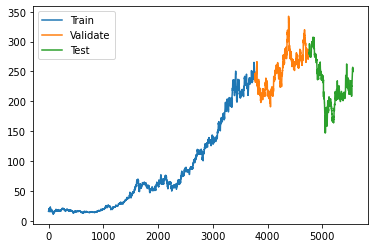

In [5]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [6]:
from sklearn.preprocessing import MinMaxScaler
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

In [10]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [11]:
import tensorflow as tf

In [12]:
keras = tf.keras
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 10
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

2022-06-11 11:37:53.960841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-11 11:37:54.056825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-11 11:37:54.057955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-11 11:37:54.071829: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/100


/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)
2022-06-11 11:38:02.615787: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


376/376 [==============================] - 18s 26ms/step - loss: 5.4993e-04 - mae: 0.0251 - lr: 1.0000e-05
Epoch 2/100
376/376 [==============================] - 9s 23ms/step - loss: 6.2723e-04 - mae: 0.0266 - lr: 1.1220e-05
Epoch 3/100
376/376 [==============================] - 8s 22ms/step - loss: 2.2451e-04 - mae: 0.0159 - lr: 1.2589e-05
Epoch 4/100
376/376 [==============================] - 8s 22ms/step - loss: 1.5902e-04 - mae: 0.0121 - lr: 1.4125e-05
Epoch 5/100
376/376 [==============================] - 9s 23ms/step - loss: 1.5191e-04 - mae: 0.0111 - lr: 1.5849e-05
Epoch 6/100
376/376 [==============================] - 9s 23ms/step - loss: 1.5133e-04 - mae: 0.0110 - lr: 1.7783e-05
Epoch 7/100
376/376 [==============================] - 9s 23ms/step - loss: 1.5161e-04 - mae: 0.0109 - lr: 1.9953e-05
Epoch 8/100
376/376 [==============================] - 9s 24ms/step - loss: 1.5207e-04 - mae: 0.0109 - lr: 2.2387e-05
Epoch 9/100
376/376 [==============================] - 9s 23ms/step

Text(0, 0.5, 'Loss')

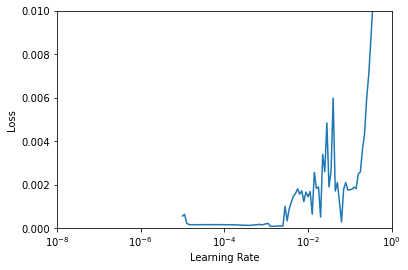

In [13]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")

In [14]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 10
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-4)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/100
    375/Unknown - 13s 24ms/step - loss: 2.4687e-04 - mae: 0.0134

2022-06-11 11:57:23.942767: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 23s 49ms/step - loss: 2.4874e-04 - mae: 0.0135 - val_loss: 0.0013 - val_mae: 0.0395
Epoch 2/100
374/376 [============================>.] - ETA: 0s - loss: 2.8952e-04 - mae: 0.0133

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 15s 40ms/step - loss: 2.9136e-04 - mae: 0.0133 - val_loss: 9.8401e-04 - val_mae: 0.0347
Epoch 3/100
374/376 [============================>.] - ETA: 0s - loss: 1.8617e-04 - mae: 0.0114

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 15s 39ms/step - loss: 1.8856e-04 - mae: 0.0115 - val_loss: 8.8546e-04 - val_mae: 0.0327
Epoch 4/100
375/376 [============================>.] - ETA: 0s - loss: 1.6024e-04 - mae: 0.0106

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 22s 59ms/step - loss: 1.6230e-04 - mae: 0.0107 - val_loss: 8.4694e-04 - val_mae: 0.0319
Epoch 5/100
375/376 [============================>.] - ETA: 0s - loss: 1.5015e-04 - mae: 0.0103

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 31s 84ms/step - loss: 1.5224e-04 - mae: 0.0104 - val_loss: 8.2543e-04 - val_mae: 0.0314
Epoch 6/100
375/376 [============================>.] - ETA: 0s - loss: 1.4301e-04 - mae: 0.0102

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 34s 91ms/step - loss: 1.4512e-04 - mae: 0.0102 - val_loss: 8.0797e-04 - val_mae: 0.0310
Epoch 7/100
376/376 [==============================] - ETA: 0s - loss: 1.3900e-04 - mae: 0.0101

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 48s 127ms/step - loss: 1.3900e-04 - mae: 0.0101 - val_loss: 7.9135e-04 - val_mae: 0.0306
Epoch 8/100
375/376 [============================>.] - ETA: 0s - loss: 1.3130e-04 - mae: 0.0098

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 55s 142ms/step - loss: 1.3343e-04 - mae: 0.0099 - val_loss: 7.7489e-04 - val_mae: 0.0302
Epoch 9/100
374/376 [============================>.] - ETA: 0s - loss: 1.2549e-04 - mae: 0.0097

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 26s 69ms/step - loss: 1.2826e-04 - mae: 0.0098 - val_loss: 7.5862e-04 - val_mae: 0.0298
Epoch 10/100
375/376 [============================>.] - ETA: 0s - loss: 1.2125e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 19s 50ms/step - loss: 1.2339e-04 - mae: 0.0096 - val_loss: 7.4288e-04 - val_mae: 0.0295
Epoch 11/100
376/376 [==============================] - ETA: 0s - loss: 1.1874e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 14s 38ms/step - loss: 1.1874e-04 - mae: 0.0095 - val_loss: 7.2808e-04 - val_mae: 0.0291
Epoch 12/100
374/376 [============================>.] - ETA: 0s - loss: 1.1140e-04 - mae: 0.0092

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 15s 39ms/step - loss: 1.1424e-04 - mae: 0.0093 - val_loss: 7.1478e-04 - val_mae: 0.0287
Epoch 13/100
375/376 [============================>.] - ETA: 0s - loss: 1.0770e-04 - mae: 0.0091

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 14s 36ms/step - loss: 1.0984e-04 - mae: 0.0092 - val_loss: 7.0365e-04 - val_mae: 0.0285
Epoch 14/100
376/376 [==============================] - ETA: 0s - loss: 1.0549e-04 - mae: 0.0090

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 14s 36ms/step - loss: 1.0549e-04 - mae: 0.0090 - val_loss: 6.9558e-04 - val_mae: 0.0283
Epoch 15/100
376/376 [==============================] - ETA: 0s - loss: 1.0117e-04 - mae: 0.0089

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


376/376 [==============================] - 14s 38ms/step - loss: 1.0117e-04 - mae: 0.0089 - val_loss: 6.9184e-04 - val_mae: 0.0282
Epoch 16/100
376/376 [==============================] - 9s 25ms/step - loss: 9.6846e-05 - mae: 0.0087 - val_loss: 6.9423e-04 - val_mae: 0.0283
Epoch 17/100
376/376 [==============================] - 11s 29ms/step - loss: 9.2538e-05 - mae: 0.0086 - val_loss: 7.0529e-04 - val_mae: 0.0286
Epoch 18/100
376/376 [==============================] - 11s 28ms/step - loss: 8.8293e-05 - mae: 0.0084 - val_loss: 7.2846e-04 - val_mae: 0.0292
Epoch 19/100
376/376 [==============================] - 10s 27ms/step - loss: 8.4212e-05 - mae: 0.0082 - val_loss: 7.6767e-04 - val_mae: 0.0302
Epoch 20/100
376/376 [==============================] - 11s 30ms/step - loss: 8.0475e-05 - mae: 0.0081 - val_loss: 8.2600e-04 - val_mae: 0.0315
Epoch 21/100
376/376 [==============================] - 9s 25ms/step - loss: 7.7347e-05 - mae: 0.0080 - val_loss: 9.0249e-04 - val_mae: 0.0331
Epoch 2

1/1 [==============================] - 1s 1s/step - loss: 1.2690e-05 - mae: 5.6651e-04


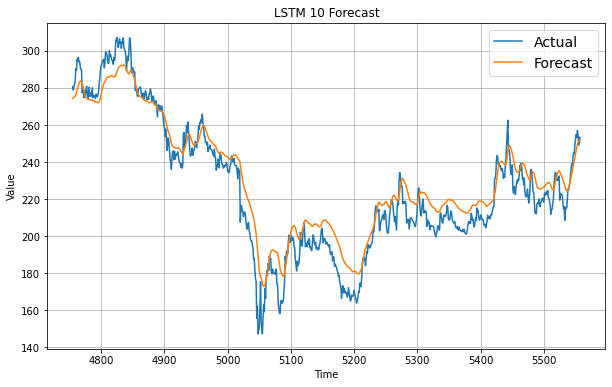

In [17]:
model = keras.models.load_model("my_checkpoint")

rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])

model.evaluate(normalized_x_test[np.newaxis,:], rnn_forecast)

rnn_forecast = rnn_forecast.flatten()

rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [16]:
model.evaluate(normalized_x_test[np.newaxis,:], )

ValueError: in user code:

    File "/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/keras/engine/training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None
